# limpiesa y lectura de datos


In [ ]:
import numpy as np
from pathlib import Path
from scipy import stats
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import KNNImputer
import plotly.express as px
import statistics 
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


In [ ]:

#import polars as pd

DATA_DIR = Path("csv").resolve()
assert DATA_DIR.exists(), f"No existe {DATA_DIR}"

# Detectar archivos
asistencia_files = sorted(DATA_DIR.glob("Asistencia_Anual_*.csv"))
rend_files = sorted(DATA_DIR.glob("Rendimiento_*.csv"))

print("Rendimiento:", [f.name for f in rend_files])

# Helper robusto de lectura
def read_csv_smart(path: Path, nrows=None):
    try:
        return pd.read_csv(path, nrows=nrows)
    except UnicodeDecodeError:
        return pd.read_csv(path, nrows=nrows, encoding="latin-1")

Rendimiento: ['Rendimiento_2022_2023.csv', 'Rendimiento_2023_2024.csv', 'Rendimiento_2024_2025.csv']


In [25]:
def read_csv_smart(path: Path, nrows=None):
    """
    Lee CSV detectando separador y encoding. Omite líneas defectuosas.
    """
    for enc in ("utf-8", "utf-8-sig", "latin-1"):
        # 1) auto-inferencia de separador (engine=python)
        try:
            return pd.read_csv(path, nrows=nrows, sep=None, engine="python",
                               encoding=enc, on_bad_lines="skip")
        except UnicodeDecodeError:
            continue
        except pd.errors.ParserError:
            pass
        # 2) intentos explícitos de separador común
        for sep in (";", "\t", "|", ","):
            try:
                return pd.read_csv(path, nrows=nrows, sep=sep, engine="python",
                                   encoding=enc, on_bad_lines="skip")
            except Exception:
                continue
    # 3) último recurso
    return pd.read_csv(path, nrows=nrows, sep=";", engine="python",
                       encoding="latin-1", on_bad_lines="skip")

# Inspección rápida de columnas
for f in asistencia_files + rend_files:
    dfh = read_csv_smart(f, nrows=5)
    print(f"\n{f.name} -> {dfh.shape}")
    print(dfh.columns.tolist())
    display(dfh.head())

# Hints para mapear nombres
COLUMN_HINTS = {
    "id": ["id", "id_alumno", "idalumno", "rut", "estudiante", "id_estudiante"],
    "anio": ["anio", "año", "ano", "periodo", "year"],
    "asistencia": ["asistencia", "asistencia_%", "porc_asistencia", "asistencia_pct"],
    "nota": ["promedio", "nota_final", "nota", "gpa"],
    "aprobado": ["aprobado", "estado", "resultado"]
}

def infer_col(df, keys):
    cols = [c for c in df.columns]
    low = {c.lower(): c for c in cols}
    for k in keys:
        for lc, orig in low.items():
            if re.search(rf"\b{k}\b", lc):
                return orig
    return None


Rendimiento_2022_2023.csv -> (5, 37)
['\ufeffAGNO', 'RBD', 'DGV_RBD', 'NOM_RBD', 'COD_REG_RBD', 'NOM_REG_RBD_A', 'COD_PRO_RBD', 'COD_COM_RBD', 'NOM_COM_RBD', 'COD_DEPROV_RBD', 'NOM_DEPROV_RBD', 'COD_DEPE', 'COD_DEPE2', 'RURAL_RBD', 'ESTADO_ESTAB', 'COD_ENSE', 'COD_ENSE2', 'COD_GRADO', 'LET_CUR', 'COD_JOR', 'COD_TIP_CUR', 'COD_DES_CUR', 'MRUN', 'GEN_ALU', 'FEC_NAC_ALU', 'EDAD_ALU', 'COD_REG_ALU', 'COD_COM_ALU', 'NOM_COM_ALU', 'COD_RAMA', 'COD_SEC', 'COD_ESPE', 'PROM_GRAL', 'ASISTENCIA', 'SIT_FIN', 'SIT_FIN_R', 'COD_MEN']


,﻿AGNO,RBD,DGV_RBD,NOM_RBD,COD_REG_RBD,NOM_REG_RBD_A,COD_PRO_RBD,COD_COM_RBD,NOM_COM_RBD,COD_DEPROV_RBD,...,COD_COM_ALU,NOM_COM_ALU,COD_RAMA,COD_SEC,COD_ESPE,PROM_GRAL,ASISTENCIA,SIT_FIN,SIT_FIN_R,COD_MEN
0,2022,1,9,LICEO POLITECNICO ARICA,15,AYP,151,15101,ARICA,151,...,15101,ARICA,400,410,41001,"6,6",98,P,P,0
1,2022,1,9,LICEO POLITECNICO ARICA,15,AYP,151,15101,ARICA,151,...,15101,ARICA,400,410,41001,0,0,Y,T,0
2,2022,1,9,LICEO POLITECNICO ARICA,15,AYP,151,15101,ARICA,151,...,15101,ARICA,400,410,41001,0,0,Y,Y,0
3,2022,1,9,LICEO POLITECNICO ARICA,15,AYP,151,15101,ARICA,151,...,15101,ARICA,400,410,41001,0,0,Y,T,0
4,2022,1,9,LICEO POLITECNICO ARICA,15,AYP,151,15101,ARICA,151,...,15101,ARICA,400,410,41001,0,0,Y,Y,0



Rendimiento_2023_2024.csv -> (5, 37)
['\ufeffAGNO', 'RBD', 'DGV_RBD', 'NOM_RBD', 'COD_REG_RBD', 'NOM_REG_RBD_A', 'COD_PRO_RBD', 'COD_COM_RBD', 'NOM_COM_RBD', 'COD_DEPROV_RBD', 'NOM_DEPROV_RBD', 'COD_DEPE', 'COD_DEPE2', 'RURAL_RBD', 'ESTADO_ESTAB', 'COD_ENSE', 'COD_ENSE2', 'COD_GRADO', 'LET_CUR', 'COD_JOR', 'COD_TIP_CUR', 'COD_DES_CUR', 'MRUN', 'GEN_ALU', 'FEC_NAC_ALU', 'EDAD_ALU', 'COD_REG_ALU', 'COD_COM_ALU', 'NOM_COM_ALU', 'COD_RAMA', 'COD_SEC', 'COD_ESPE', 'PROM_GRAL', 'ASISTENCIA', 'SIT_FIN', 'SIT_FIN_R', 'COD_MEN']


,﻿AGNO,RBD,DGV_RBD,NOM_RBD,COD_REG_RBD,NOM_REG_RBD_A,COD_PRO_RBD,COD_COM_RBD,NOM_COM_RBD,COD_DEPROV_RBD,...,COD_COM_ALU,NOM_COM_ALU,COD_RAMA,COD_SEC,COD_ESPE,PROM_GRAL,ASISTENCIA,SIT_FIN,SIT_FIN_R,COD_MEN
0,2023,1,9,LICEO POLITECNICO ARICA,15,AYP,151,15101,ARICA,151,...,15101,ARICA,400,410,41001,0,0,Y,Y,0
1,2023,1,9,LICEO POLITECNICO ARICA,15,AYP,151,15101,ARICA,151,...,15101,ARICA,400,410,41001,"5,7",94,P,P,0
2,2023,1,9,LICEO POLITECNICO ARICA,15,AYP,151,15101,ARICA,151,...,15101,ARICA,400,410,41001,0,0,Y,Y,0
3,2023,1,9,LICEO POLITECNICO ARICA,15,AYP,151,15101,ARICA,151,...,15101,ARICA,400,410,41001,"6,7",100,P,P,0
4,2023,1,9,LICEO POLITECNICO ARICA,15,AYP,151,15101,ARICA,151,...,15101,ARICA,400,410,41001,0,0,Y,Y,0



Rendimiento_2024_2025.csv -> (5, 38)
['\ufeffAGNO', 'RBD', 'DGV_RBD', 'NOM_RBD', 'COD_REG_RBD', 'NOM_REG_RBD_A', 'COD_PRO_RBD', 'COD_COM_RBD', 'NOM_COM_RBD', 'COD_DEPROV_RBD', 'NOM_DEPROV_RBD', 'COD_DEPE', 'COD_DEPE2', 'RURAL_RBD', 'ESTADO_ESTAB', 'NOMBRE_SLEP', 'COD_ENSE', 'COD_ENSE2', 'COD_GRADO', 'LET_CUR', 'COD_JOR', 'COD_TIP_CUR', 'COD_DES_CUR', 'MRUN', 'GEN_ALU', 'FEC_NAC_ALU', 'EDAD_ALU', 'COD_REG_ALU', 'COD_COM_ALU', 'NOM_COM_ALU', 'COD_RAMA', 'COD_SEC', 'COD_ESPE', 'PROM_GRAL', 'ASISTENCIA', 'SIT_FIN', 'SIT_FIN_R', 'COD_MEN']


,﻿AGNO,RBD,DGV_RBD,NOM_RBD,COD_REG_RBD,NOM_REG_RBD_A,COD_PRO_RBD,COD_COM_RBD,NOM_COM_RBD,COD_DEPROV_RBD,...,COD_COM_ALU,NOM_COM_ALU,COD_RAMA,COD_SEC,COD_ESPE,PROM_GRAL,ASISTENCIA,SIT_FIN,SIT_FIN_R,COD_MEN
0,2024,1,9,LICEO POLITECNICO ARICA,15,AYP,151,15101,ARICA,151,...,15101,ARICA,400,410,41001,"6,2",99,P,P,0
1,2024,1,9,LICEO POLITECNICO ARICA,15,AYP,151,15101,ARICA,151,...,15101,ARICA,400,410,41001,0,0,Y,T,0
2,2024,1,9,LICEO POLITECNICO ARICA,15,AYP,151,15101,ARICA,151,...,15101,ARICA,400,410,41001,"5,2",85,R,R,0
3,2024,1,9,LICEO POLITECNICO ARICA,15,AYP,151,15101,ARICA,151,...,15101,ARICA,400,410,41001,"5,8",98,P,P,0
4,2024,1,9,LICEO POLITECNICO ARICA,15,AYP,151,15101,ARICA,151,...,15101,ARICA,400,410,41001,0,0,Y,T,0


In [26]:

# Asegurar carpeta de salida
OUT_DIR.mkdir(parents=True, exist_ok=True)

for f in rend_files:
    fpath = Path(f)
    df = read_csv_smart(fpath)

    # normalizar nombres de columna (quitar BOM, espacios, pasar a mayúsculas)
    cols = [str(c).strip().lstrip("\ufeff").upper() for c in df.columns]
    df.columns = cols

    # Crear dataframe de salida con las columnas EXACTAS en el orden requerido
    DFOut = pd.DataFrame(index=df.index)
    for col in REQUIRED_REND:
        if col in df.columns:
            DFOut[col] = df[col]
        else:
            DFOut[col] = np.nan

    # Limpiezas por columna
    if "PROM_GRAL" in DFOut.columns:
        s = DFOut["PROM_GRAL"].astype(str).str.replace(",", ".", regex=False)
        s = s.replace({"nan": np.nan, "": np.nan})
        DFOut["PROM_GRAL"] = pd.to_numeric(s, errors="coerce")

    if "ASISTENCIA" in DFOut.columns:
        s = DFOut["ASISTENCIA"].astype(str).str.replace(",", ".", regex=False).str.replace("%", "", regex=False)
        s = s.replace({"nan": np.nan, "": np.nan})
        DFOut["ASISTENCIA"] = pd.to_numeric(s, errors="coerce")

    for c in ("SIT_FIN", "SIT_FIN_R"):
        if c in DFOut.columns:
            s = DFOut[c].astype(str).str.strip()
            s = s.replace({"nan": np.nan, "": np.nan})
            DFOut[c] = s

    if "MRUN" in DFOut.columns:
        # preservar ceros a la izquierda y limpiar espacios
        DFOut["MRUN"] = DFOut["MRUN"].astype(str).str.strip().replace({"nan": np.nan})

    if "EDAD_ALU" in DFOut.columns:
        DFOut["EDAD_ALU"] = pd.to_numeric(DFOut["EDAD_ALU"], errors="coerce").astype("Int64")

    for c in ("NOM_RBD", "GEN_ALU"):
        if c in DFOut.columns:
            DFOut[c] = DFOut[c].astype(str).str.strip().replace({"nan": np.nan})

    # Guardar en el orden requerido
    out_path = OUT_DIR / (fpath.stem + "_clean.csv")
    DFOut.to_csv(out_path, index=False)
    print("Guardado:", out_path.name)


Guardado: Rendimiento_2022_2023_clean.csv
Guardado: Rendimiento_2023_2024_clean.csv
Guardado: Rendimiento_2024_2025_clean.csv


# temp


In [ ]:


def load_rendimiento_clean(data_dir: str = "datasets/csvClear") -> pd.DataFrame:
    base = Path(data_dir)
    files = sorted(base.glob("Rendimiento_*_clean.csv"))
    if not files:
        raise FileNotFoundError(f"No se encontraron archivos *_clean en {base}. Ejecuta datasets/leercsv.ipynb primero.")

    dfs = []
    for f in files:
        df = pd.read_csv(f)
        # Normalizar columnas
        df.columns = [str(c).strip().upper().lstrip("\ufeff") for c in df.columns]
        # Asegurar columnas esperadas
        for c in ("AGNO","MRUN","PROM_GRAL","ASISTENCIA","SIT_FIN","SIT_FIN_R"):
            if c not in df.columns:
                df[c] = np.nan

        df["AGNO"] = pd.to_numeric(df["AGNO"], errors="coerce").astype("Int64")
        df["MRUN"] = df["MRUN"].astype(str).str.strip()
        df["PROM_GRAL"] = pd.to_numeric(df["PROM_GRAL"], errors="coerce")
        df["ASISTENCIA"] = pd.to_numeric(df["ASISTENCIA"], errors="coerce")

        for c in ("SIT_FIN","SIT_FIN_R"):
            df[c] = df[c].astype(str).str.strip().replace({"nan": np.nan, "None": np.nan})

        df["SOURCE_FILE"] = f.name
        dfs.append(df)

    full = pd.concat(dfs, ignore_index=True)

    # Normalizar asistencia a 0-100 y recortar a rango válido
    mask_01 = full["ASISTENCIA"].between(0, 1, inclusive="both")
    full.loc[mask_01, "ASISTENCIA"] = full.loc[mask_01, "ASISTENCIA"] * 100
    full["ASISTENCIA"] = full["ASISTENCIA"].clip(lower=0, upper=100)

    # Filtrar MRUN vacíos y deduplicar por AGNO+MRUN
    full = full[full["MRUN"].notna() & (full["MRUN"].str.len() > 0)].copy()
    full = full.sort_values(["AGNO","MRUN"]).drop_duplicates(["AGNO","MRUN"], keep="last")

    return full
# ...existing code...

In [ ]:
def build_label_aprobacion(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    y = pd.Series(np.nan, index=df.index, dtype="float")

    # Preferir SIT_FIN_R
    s = df["SIT_FIN_R"].fillna("").str.lower()
    aprob = s.str.contains(r"apro|promov") & ~s.str.contains(r"no\s*apro")
    reprob = s.str.contains(r"reprob|repit|retir|deser|elim|baja|aband")
    y.loc[aprob] = 1
    y.loc[reprob] = 0

    # Fallback SIT_FIN
    s2 = df["SIT_FIN"].fillna("").str.lower()
    aprob2 = s2.str.contains(r"apro|promov") & ~s2.str.contains(r"no\s*apro")
    reprob2 = s2.str.contains(r"reprob|repit|retir|deser|elim|baja|aband")
    y.loc[y.isna() & aprob2] = 1
    y.loc[y.isna() & reprob2] = 0

    # Regla por nota
    nota = pd.to_numeric(df["PROM_GRAL"], errors="coerce")
    y.loc[y.isna() & (nota >= 4.0)] = 1
    y.loc[y.isna() & (nota < 4.0)] = 0

    df["label_aprobado"] = y.astype("Int64")
    return df
# ...existing code...

In [ ]:
FEATURE_COLS_EDU = ["prom_gral", "asistencia_pct"]

def engineer_features_edu(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["prom_gral"] = pd.to_numeric(df["PROM_GRAL"], errors="coerce").clip(lower=1.0, upper=7.0)
    df["asistencia_pct"] = (pd.to_numeric(df["ASISTENCIA"], errors="coerce")/100.0).clip(lower=0.0, upper=1.0)
    df["agno"] = pd.to_numeric(df["AGNO"], errors="coerce").astype("Int64")
    return df

In [39]:
df1 = pd.read_csv('csvClear/Rendimiento_2022_2023_clean.csv')
df2 = pd.read_csv('csvClear/Rendimiento_2023_2024_clean.csv')
df3 = pd.read_csv('csvClear/Rendimiento_2024_2025_clean.csv')

In [40]:
valid_columns = ["AGNO","MRUN","NOM_RBD","GEN_ALU","EDAD_ALU","PROM_GRAL","ASISTENCIA","SIT_FIN"]
# Seleccionar columnas solicitadas (case-insensitive). Las que falten se crean con NaN
df1 = df1[[col for col in df1.columns if col.upper() in valid_columns]]
df2 = df2[[col for col in df2.columns if col.upper() in valid_columns]]
df3 = df3[[col for col in df3.columns if col.upper() in valid_columns]]

In [68]:
df1

,AGNO,MRUN,NOM_RBD,GEN_ALU,EDAD_ALU,PROM_GRAL,ASISTENCIA,SIT_FIN
0,2022,459781,LICEO POLITECNICO ARICA,1,40.0,6.6,98,P
1,2022,974395,LICEO POLITECNICO ARICA,2,55.0,0.0,0,Y
2,2022,1959596,LICEO POLITECNICO ARICA,1,45.0,0.0,0,Y
3,2022,2267103,LICEO POLITECNICO ARICA,2,21.0,0.0,0,Y
4,2022,2306638,LICEO POLITECNICO ARICA,1,18.0,0.0,0,Y
...,...,...,...,...,...,...,...,...
3405125,2022,25620942,ESCUELA HOSPITALARIA PROVINCIA CORDILLERA PUEN...,1,20.0,0.0,100,NaN
3405126,2022,785298,ESCUELA HOSPITALARIA PROVINCIA CORDILLERA PUEN...,1,17.0,0.0,0,Y
3405127,2022,3905129,ESCUELA HOSPITALARIA PROVINCIA CORDILLERA PUEN...,2,18.0,0.0,0,Y
3405128,2022,13783110,ESCUELA HOSPITALARIA PROVINCIA CORDILLERA PUEN...,1,17.0,0.0,0,Y


In [45]:
df1.isna().sum()

AGNO            0
MRUN            0
NOM_RBD         0
GEN_ALU         0
EDAD_ALU      351
PROM_GRAL       0
ASISTENCIA      0
SIT_FIN       748
dtype: int64

In [46]:
df2.isna().sum()

AGNO             0
MRUN             0
NOM_RBD          0
GEN_ALU          0
EDAD_ALU       410
PROM_GRAL        0
ASISTENCIA       0
SIT_FIN       2005
dtype: int64

In [47]:
df3.isna().sum()

AGNO             0
MRUN             0
NOM_RBD          0
GEN_ALU          0
EDAD_ALU       397
PROM_GRAL        0
ASISTENCIA       0
SIT_FIN       3476
dtype: int64

In [50]:
DFIni1 = df1.drop(['EDAD_ALU',"SIT_FIN"], axis=1)
DFIni2 = df2.drop(['EDAD_ALU',"SIT_FIN"], axis=1)
DFIni3 = df3.drop(['EDAD_ALU',"SIT_FIN"], axis=1)

In [51]:
DFIni1.isna().sum()

AGNO          0
MRUN          0
NOM_RBD       0
GEN_ALU       0
PROM_GRAL     0
ASISTENCIA    0
dtype: int64

In [69]:
# Unir df1, df2, df3 en un solo DataFrame
import pandas as pd
from pathlib import Path

# Asegurar que existen
assert 'df1' in globals() and 'df2' in globals() and 'df3' in globals()

# Concatenar y homogenizar columnas
common_cols = sorted(set(df1.columns) & set(df2.columns) & set(df3.columns))
df_all = pd.concat([df1[common_cols], df2[common_cols], df3[common_cols]], ignore_index=True)

# Deduplicar por (AGNO, MRUN) si aplica
if {'AGNO','MRUN'}.issubset(df_all.columns):
    df_all['AGNO'] = pd.to_numeric(df_all['AGNO'], errors='coerce').astype('Int64')
    df_all['MRUN'] = df_all['MRUN'].astype(str).str.strip()
    df_all = df_all.sort_values(['AGNO','MRUN']).drop_duplicates(['AGNO','MRUN'], keep='last')

print(df_all.shape)
df_all.head()

# (Opcional) Guardar combinado
out_path = Path('csvClear') / 'Rendimiento_all_clean.csv'
out_path.parent.mkdir(parents=True, exist_ok=True)
df_all.to_csv(out_path, index=False)
print(f'Guardado: {out_path}')

(9859119, 8)
Guardado: csvClear/Rendimiento_all_clean.csv


In [70]:
DFIniJoin = pd.read_csv('csvClear/Rendimiento_all_clean.csv')   

In [71]:
DFIniJoin

,AGNO,ASISTENCIA,EDAD_ALU,GEN_ALU,MRUN,NOM_RBD,PROM_GRAL,SIT_FIN
0,2022,100,12.0,2,1000,ESCUELA RURAL PILMAIQUEN,5.7,P
1,2022,97,14.0,1,10000000,CENTRO POLITECNICO PARTICULAR CONCHALI,6.1,P
2,2022,77,14.0,1,10000001,LICEO ENRIQUE BALLACEY COTTEREAU,5.7,P
3,2022,95,11.0,2,10000029,COLEGIO BICENTENARIO ARZOBISPO CRESCENTE ERRAZ...,5.9,P
4,2022,87,10.0,1,10000031,COLEGIO JOSE LUIS LEGRANGE DE LA CISTERNA,6.0,P
...,...,...,...,...,...,...,...,...
9859114,2024,83,12.0,1,9999867,INSTITUTO MIGUEL LEON PRADO,6.4,P
9859115,2024,91,12.0,1,9999868,ESCUELA PARTICULAR PADRE ALEJANDRO ORTEGA,5.8,P
9859116,2024,100,10.0,1,9999893,COLEGIO PACIFIC SCHOOL,6.2,P
9859117,2024,37,18.0,1,9999956,LICEO DOCTOR ROBERTO HUMERES O.,5.7,P


In [72]:
print(DFIniJoin[['AGNO','MRUN','GEN_ALU','PROM_GRAL','ASISTENCIA']].describe())

               AGNO          MRUN       GEN_ALU     PROM_GRAL    ASISTENCIA
count  9.859119e+06  9.859119e+06  9.859119e+06  9.859119e+06  9.859119e+06
mean   2.023016e+03  1.560421e+07  1.482615e+00  5.495462e+00  8.338842e+01
std    8.119531e-01  8.554934e+06  4.997036e-01  1.822049e+00  2.414615e+01
min    2.022000e+03  3.100000e+01  0.000000e+00  0.000000e+00  0.000000e+00
25%    2.022000e+03  8.087567e+06  1.000000e+00  5.500000e+00  8.400000e+01
50%    2.023000e+03  1.617655e+07  1.000000e+00  6.100000e+00  9.100000e+01
75%    2.024000e+03  2.425727e+07  2.000000e+00  6.500000e+00  9.600000e+01
max    2.024000e+03  2.791177e+07  2.000000e+00  7.000000e+00  1.000000e+02


In [78]:
# Calcular z-score solo sobre las columnas numéricas (evita errores por columnas string/obj)
num_cols = DFIniJoin.select_dtypes(include=[np.number]).columns.tolist()
if not num_cols:
	raise ValueError("No hay columnas numéricas en DFIniJoin para calcular z-score.")

arr = stats.zscore(DFIniJoin[num_cols], nan_policy='omit')
arr = np.asarray(arr)
if arr.ndim == 1:
	arr = arr.reshape(-1, 1)

z = np.abs(arr)
z_df = pd.DataFrame(z, columns=num_cols, index=DFIniJoin.index)

mask_valid = (z_df < 2).all(axis=1)

DFinal = DFIniJoin[mask_valid].copy()

print("Forma original:", DFIniJoin.shape)
print("Forma filtrada (Z-score):", DFinal.shape)

Forma original: (9859119, 8)
Forma filtrada (Z-score): (8777765, 8)


In [ ]:
from matplotlib import pyplot as plt


def boxplot_3cols(df, cols, title):
    if len(cols) != 2:
        raise ValueError("Debes pasar exactamente 2 columnas en 'cols'.")
    for c in cols:
        if c not in df.columns:
            raise KeyError(f"La columna '{c}' no existe en el DataFrame.")
    plt.figure(figsize=(7, 5))
    # Boxplot agrupado por sexo
    sns.boxplot(x=cols[0], y=cols[1], data=df)
    plt.title(title)
    plt.ylabel("Cupo Máximo (CUPO_MX)")
    plt.xlabel("Sexo (0=Mujer, 1=Hombre)")
    plt.tight_layout()
    plt.show()

# 1) Define las columnas: Sexo y CUPO_MX
cols = ["Sexo", "CUPO_MX"]

# 2) Boxplot ANTES del filtrado por Z-score
boxplot_3cols(DFIniJoin, cols, "ANTES (Z-score): Cupo Máximo por Sexo")

# 3) Boxplot DESPUÉS del filtrado por Z-score
z = np.abs(stats.zscore(DFIniJoin[["CUPO_MX"]], nan_policy="omit"))
mask_valid = (z < 8).all(axis=1)
DFinal = DFIniJoin[mask_valid].copy()
boxplot_3cols(DFinal, cols, "DESPUÉS (Z-score): Cupo Máximo por Sexo")

KeyError: "La columna 'Sexo' no existe en el DataFrame."

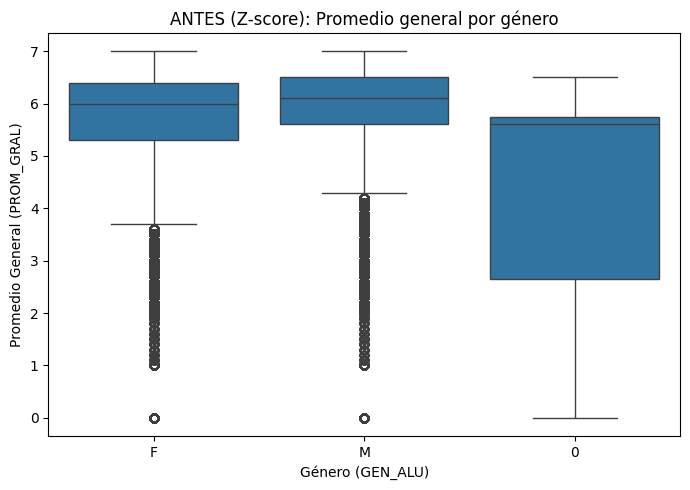

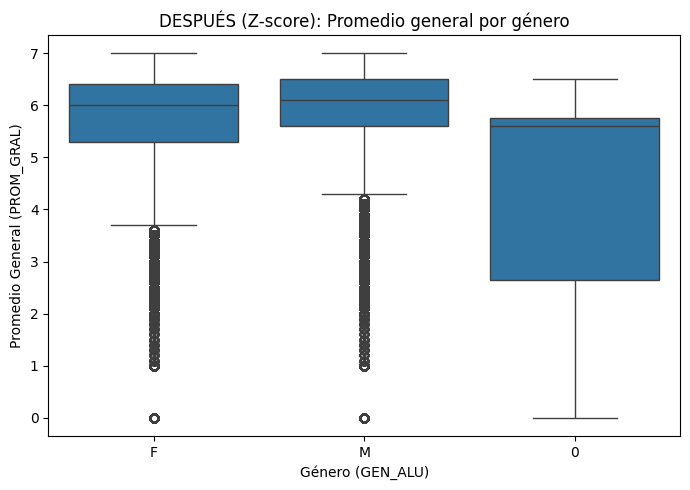

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def boxplot_grouped(df, x_col, y_col, title, top_n=None):
    if x_col not in df.columns or y_col not in df.columns:
        raise KeyError(f"Faltan columnas: {x_col} o {y_col}")
    tmp = df[[x_col, y_col]].copy()
    tmp[y_col] = pd.to_numeric(tmp[y_col], errors="coerce")
    tmp = tmp.dropna(subset=[y_col])
    # Tratar el eje X como categórico (útil para AGNO)
    tmp[x_col] = tmp[x_col].astype(str)
    if top_n:
        keep = tmp[x_col].value_counts().index[:top_n]
        tmp = tmp[tmp[x_col].isin(keep)]
    plt.figure(figsize=(8,5))
    sns.boxplot(data=tmp, x=x_col, y=y_col)
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.tight_layout()
    plt.show()

# Base combinada
base = DFIniJoin.copy()

# 1) PROM_GRAL por AGNO (antes y después de filtrar outliers)
boxplot_grouped(base, "AGNO", "PROM_GRAL", "PROM_GRAL por AGNO (antes)")
serie_pg = pd.to_numeric(base["PROM_GRAL"], errors="coerce")
z_pg = np.abs((serie_pg - serie_pg.mean()) / serie_pg.std(ddof=0))
base_pg_ok = base[z_pg < 3].copy()
boxplot_grouped(base_pg_ok, "AGNO", "PROM_GRAL", "PROM_GRAL por AGNO (después Z<3)")

# 2) ASISTENCIA por SIT_FIN_R (si existe), limitando a top 6 categorías
if "SIT_FIN_R" in base.columns:
    boxplot_grouped(base, "SIT_FIN_R", "ASISTENCIA", "ASISTENCIA por SIT_FIN_R (antes)", top_n=6)
    serie_as = pd.to_numeric(base["ASISTENCIA"], errors="coerce")
    z_as = np.abs((serie_as - serie_as.mean()) / serie_as.std(ddof=0))
    base_as_ok = base[z_as < 3].copy()
    boxplot_grouped(base_as_ok, "SIT_FIN_R", "ASISTENCIA", "ASISTENCIA por SIT_FIN_R (después Z<3)", top_n=6)